In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

from IPython import display

# from utils import Logger
from IPython.display import clear_output
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score
plt.ion()
plt.show()


https://github.com/diegoalejogm/gans/blob/master/1.%20Vanilla%20GAN%20PyTorch.ipynb

In [2]:
# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)
num_epochs = 30000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1


In [3]:
def get_gaussian(mu, sigma, n):
    return torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_noise(m, n):
    return torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

In [4]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

In [6]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent = 2.0):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

(array([ 55.,  23.,  13.,  29.,  40.,  17.,  19.,   2.,   0.,   2.]),
 array([  3.42297426e-08,   9.23582871e-01,   1.84716571e+00,
          2.77074854e+00,   3.69433138e+00,   4.61791422e+00,
          5.54149705e+00,   6.46507989e+00,   7.38866273e+00,
          8.31224556e+00,   9.23582840e+00]),
 <a list of 10 Patch objects>)

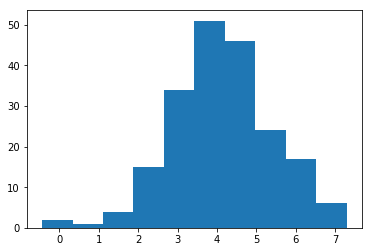

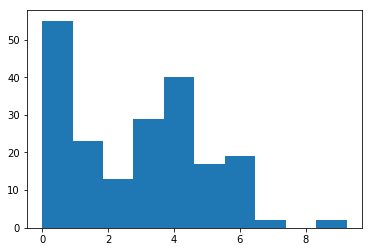

In [20]:
plt.hist(Variable(get_gaussian(4, 1.25, 200)).data.numpy()[0])
plt.figure()

plt.hist(decorate_with_diffs(Variable(get_gaussian(4, 1.25, 100))).data.numpy()[0])

In [8]:
# x = np.full((1,5), 2)
# print('1. ', x)
# # x = Variable(torch.from_numpy(x))
# # x = torch.Tensor(np.random.normal(4, 1.25, (1, 5)))
# x = torch.Tensor(x)
# print('2. ', x)
# x = Variable(x)
# mean = torch.mean(x.data, 1, keepdim=True)
# print('3. mean ', mean)
# mean_broadcast = torch.mul(torch.ones(x.size()), mean.tolist()[0][0])
# print('4. mean_broadcast ', mean_broadcast)
# diffs = torch.pow(x - Variable(mean_broadcast), 2)
# print('5. diffs ', diffs)
# torch.cat([x, diffs], 1)

In [15]:
# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'


G = Generator(input_size=1, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=2 * d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

.

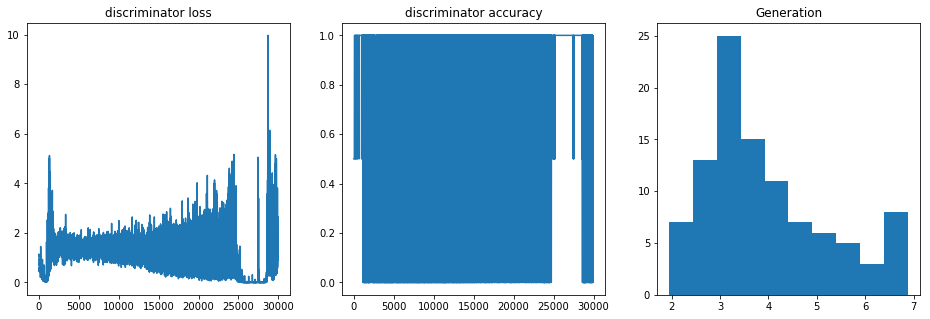

In [14]:
d_losses = []
d_acc = []
# for epoch in range(2):
for epoch in range(num_epochs):

    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(get_gaussian(data_mean, data_stddev, d_input_size))
        d_real_decision = D(decorate_with_diffs(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params


        #  1B: Train D on fake
        d_gen_input = Variable(get_noise(d_input_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(decorate_with_diffs(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()

        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
        
        
        ## Loss & accuracy 
        d_losses.append(d_real_error.data.numpy()[0] + d_fake_error.data.numpy()[0])
        d_pred = [(d_real_decision > 0.5).data.numpy()[0][0], (d_fake_decision >0.5).data.numpy()[0][0]]
        truth = [1,0]
        d_acc.append(accuracy_score(truth, d_pred))
        

    gen = []
    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(get_noise(d_input_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(decorate_with_diffs(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine
        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        gen = g_fake_data.data.numpy().flatten()

    if epoch % 100 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(16, 5))
        plt.subplot(1,3,1)
        plt.title('discriminator loss')
        plt.plot(d_losses)
        
        
        plt.subplot(1,3,2)
        plt.title('discriminator accuracy')
        plt.plot(d_acc)
        
        print('.', end = '')
        # plot results
        plt.subplot(1,3,3)
        plt.title('Generation')
        plt.hist(gen) 
        plt.show()

#         print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
#                                                             extract(d_real_error)[0],
#                                                             extract(d_fake_error)[0],
#                                                             extract(g_error)[0],
#                                                             stats(extract(d_real_data)),
#                                                             stats(extract(d_fake_data))))

In [18]:
d_losses = []
d_acc = []
# for epoch in range(2):
for epoch in range(1):

    for d_index in range(1):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(get_gaussian(data_mean, data_stddev, d_input_size))
#         print('decorate_with_diffs(d_real_data) ', decorate_with_diffs(d_real_data).size())
        d_real_decision = D(decorate_with_diffs(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params


        #  1B: Train D on fake
        print('get_noise(d_input_size, g_input_size) ', get_noise(d_input_size, g_input_size).size())
        d_gen_input = Variable(get_noise(d_input_size, g_input_size))
        print('d_gen_input', d_gen_input.size())
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        print('d_fake_data', d_fake_data.size())
        d_fake_decision = D(decorate_with_diffs(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()

        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

        



C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1189: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


get_noise(d_input_size, g_input_size)  torch.Size([100, 1])
d_gen_input torch.Size([100, 1])
d_fake_data torch.Size([100, 1])


In [ ]:
class XX(object):
    blah = 3
    def __init__(self, d):
        self.__dict__.update(**d)
        self.asdasd = 3
        
        self.blah = 1
x = XX({'ddd':3, 'uuu' : 'ouuuu'})

x.__dict__

In [ ]:
x.uuu